In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.config import paths, params


cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

In [3]:
import json

CONFIG_PATH = os.path.join('cell_inference/resources/simulation_data/1000s_y1Loc2Alt_Ori2_Geo3_params/config0.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
ranges['y'] = [-100, 100]
feature_range = (-1, 1)

print(inference_list)
print(ranges)

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, '1000s_y1Loc2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'summ_stats0.npz')  # LFP and labels

summ_stats   = np.load(LFP_PATH)['x']
labels = np.load(LFP_PATH)['y']

labels[:,0] = np.load(LFP_PATH)['ys']

df_la = pd.DataFrame(labels, columns=inference_list).sort_values(by='y')
# display(df_la)
df_bet_la = df_la[df_la['y'].between(-100, 100)].index.values

labels = labels[df_bet_la,:]
summ_stats = summ_stats[df_bet_la,:]
display(df_la[df_la['y'].between(-100, 100)])

['y', 'd', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
{'x': [-50, 50], 'y': [-100, 100], 'z': [20.0, 200.0], 'alpha': [0, 3.141592653589793], 'h': [-1.0, 1.0], 'phi': [-3.141592653589793, 3.141592653589793], 'd': [20.0, 200.0], 'theta': [-1.0471975511965976, 1.0471975511965976], 'r_s': [7.0, 12.0], 'l_t': [20.0, 800.0], 'r_t': [0.6, 1.8], 'r_d': [0.1, 0.8], 'r_tu': [0.1, 0.8], 'l_d': [100.0, 300.0]}


,y,d,theta,h,phi,r_s,l_t,r_t
889,-99.122356,158.567656,-0.282863,-0.602610,-2.723164,9.146831,298.260572,1.082463
235,-96.539589,55.502291,-0.605595,-0.803406,2.010273,8.936617,317.455527,1.548819
215,-96.525035,177.234074,-0.398543,0.908610,0.578021,10.245818,52.762555,0.877110
502,-94.839032,52.888206,0.047551,-0.877754,-2.328690,10.672544,101.318815,1.456209
77,-93.292155,190.809861,-0.013818,-0.501318,-1.984062,11.886048,486.295251,1.207861
...,...,...,...,...,...,...,...,...
504,95.969824,181.585718,-0.649512,0.844816,2.558533,7.377579,87.041720,1.068007
269,97.727256,153.988531,0.297392,0.571833,-3.131668,11.248819,737.365449,1.403897
901,97.880291,136.032043,0.393296,0.626986,3.000355,8.189393,628.632922,1.299157
433,98.605421,103.316206,-0.322245,0.700942,2.492166,8.062453,178.569475,0.602166


In [4]:
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

def test_max():
    lp = os.path.join(TRIAL_PATH, 'lfp0.npz')  # LFP and labels
    lfp = np.load(lp)['x']
    print(lfp.shape)

    dp = 'cell_inference/resources/invivo'
    invp = os.path.join(dp, 'all_cell_LFP_2D.h5')

    with h5py.File(invp, "r") as f:
        c = f['coord'][:]
        d = f['data'][:]  # time x channels x samples

    t = np.arange(d.shape[0])

    filtered_lfp = d

    pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
    lfp_list = []
    for i in range(d.shape[2]):
        #     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
        fst_idx = first_pk_tr(filtered_lfp[:,:,i])
        start, end = get_spike_window(filtered_lfp[:,:,i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
        lfp_list.append(filtered_lfp[start:end, :, i])

    windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
    maxs = []
    for i in range(windowed_lfp.shape[0]):
        maxs.append(np.amax(windowed_lfp[i,:,:]))
    avg_invp_max = sum(maxs)/len(maxs)
    
    maxs = []
    for i in range(lfp.shape[0]):
        maxs.append(np.amax(lfp[i,:,:]))
    avg_styl_max = sum(maxs)/len(maxs)
    
    return avg_invp_max, avg_styl_max

invp_max, styl_max = test_max()
print(invp_max, styl_max)
    

(989, 176, 384)
63.11795381784929 0.008175672876949383


In [5]:
for i in range(labels.shape[1]):
    label = labels[:, i]
    label_name = inference_list[i]
    min_max_range = ranges[label_name]
    x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
    x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
    labels[:, i] = x_scaled
df_la = pd.DataFrame(labels, columns=inference_list).sort_values(by='y')
display(df_la)

,y,d,theta,h,phi,r_s,l_t,r_t
0,-0.991224,0.539641,-0.270114,-0.602610,-0.866810,-0.141268,-0.286511,-0.195894
1,-0.965396,-0.605530,-0.578301,-0.803406,0.639890,-0.225353,-0.237294,0.581365
2,-0.965250,0.747045,-0.380581,0.908610,0.183990,0.298327,-0.915993,-0.538151
3,-0.948390,-0.634575,0.045408,-0.877754,-0.741245,0.469018,-0.791490,0.427015
4,-0.932922,0.897887,-0.013195,-0.501318,-0.631546,0.954419,0.195629,0.013102
...,...,...,...,...,...,...,...,...
868,0.959698,0.795397,-0.620238,0.844816,0.814406,-0.848969,-0.828098,-0.219989
869,0.977273,0.488761,0.283988,0.571833,-0.996841,0.699528,0.839399,0.339828
870,0.978803,0.289245,0.375570,0.626986,0.955043,-0.524243,0.560597,0.165261
871,0.986054,-0.074264,-0.307721,0.700942,0.793281,-0.575019,-0.593412,-0.996391


In [6]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch


model = FullyConnectedNetwork(in_features=40, out_features=8)
PATH = 'cell_inference/resources/simulation_data/1000s_y1Loc2Alt_Ori2_Geo3_params/batch128_model.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [7]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.feature_extractors.helperfunctions import build_dataloader_from_numpy
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device("cpu")

train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=512, shuffle=True)

x, y = next(iter(test_loader))
model.eval()
x = x.to(device)
output = model(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score Y-Shift: {}'.format(r2_score(y[:,0], output[:,0])))
print('R2 Score D: {}'.format(r2_score(y[:,1], output[:,1])))
print('R2 Score Theta: {}'.format(r2_score(y[:,2], output[:,2])))
print('R2 Score h: {}'.format(r2_score(y[:,3], output[:,3])))
print('R2 Score Phi: {}'.format(r2_score(y[:,4], output[:,4])))
print('R2 Score Soma Radius: {}'.format(r2_score(y[:,5], output[:,5])))
print('R2 Score Trunk Length: {}'.format(r2_score(y[:,6], output[:,6])))
print('R2 Score Trunk Width: {}'.format(r2_score(y[:,7], output[:,7])))


# print(output.shape)
# print(y.shape)

df_la = pd.DataFrame(y, columns=inference_list).sort_values(by='y')
display(df_la)
# print(y[:,0])
# print(output[:,0])

R2 Score Y-Shift: 0.8328088141420502
R2 Score D: 0.9509316833734928
R2 Score Theta: 0.13800739165722298
R2 Score h: 0.9397654944056775
R2 Score Phi: 0.7879083510543049
R2 Score Soma Radius: 0.0021926989668614727
R2 Score Trunk Length: 0.8118155227016826
R2 Score Trunk Width: 0.8500597346041118


,y,d,theta,h,phi,r_s,l_t,r_t
162,-0.991224,0.539641,-0.270114,-0.602610,-0.866810,-0.141268,-0.286511,-0.195894
2,-0.965250,0.747045,-0.380581,0.908610,0.183990,0.298327,-0.915993,-0.538151
214,-0.932922,0.897887,-0.013195,-0.501318,-0.631546,0.954419,0.195629,0.013102
38,-0.867277,-0.516194,-0.701022,-0.769224,0.649882,0.506998,0.986343,0.792135
179,-0.855456,0.327367,0.621486,-0.579886,0.884729,-0.718257,0.114734,0.932220
...,...,...,...,...,...,...,...,...
165,0.684063,0.680563,0.103459,-0.705516,-0.496355,-0.735923,-0.083739,0.092889
94,0.843687,0.131548,-0.066408,0.571742,-0.993583,0.459378,-0.506677,0.642050
192,0.871518,-0.236370,-0.222932,0.986703,-0.890037,0.674921,-0.999219,-0.627910
184,0.877099,0.868572,0.368856,-0.619454,-0.341135,0.076237,0.649140,-0.649987


In [8]:
if True:
    for i in range(y.shape[1]):
        old_y = y[:,i]
        old_out = output[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_y = (((old_y - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        
        org_out = (((old_out - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        y[:,i] = org_y
        output[:,i] = org_out

# print(y[:,0])
# print(output[:,0])

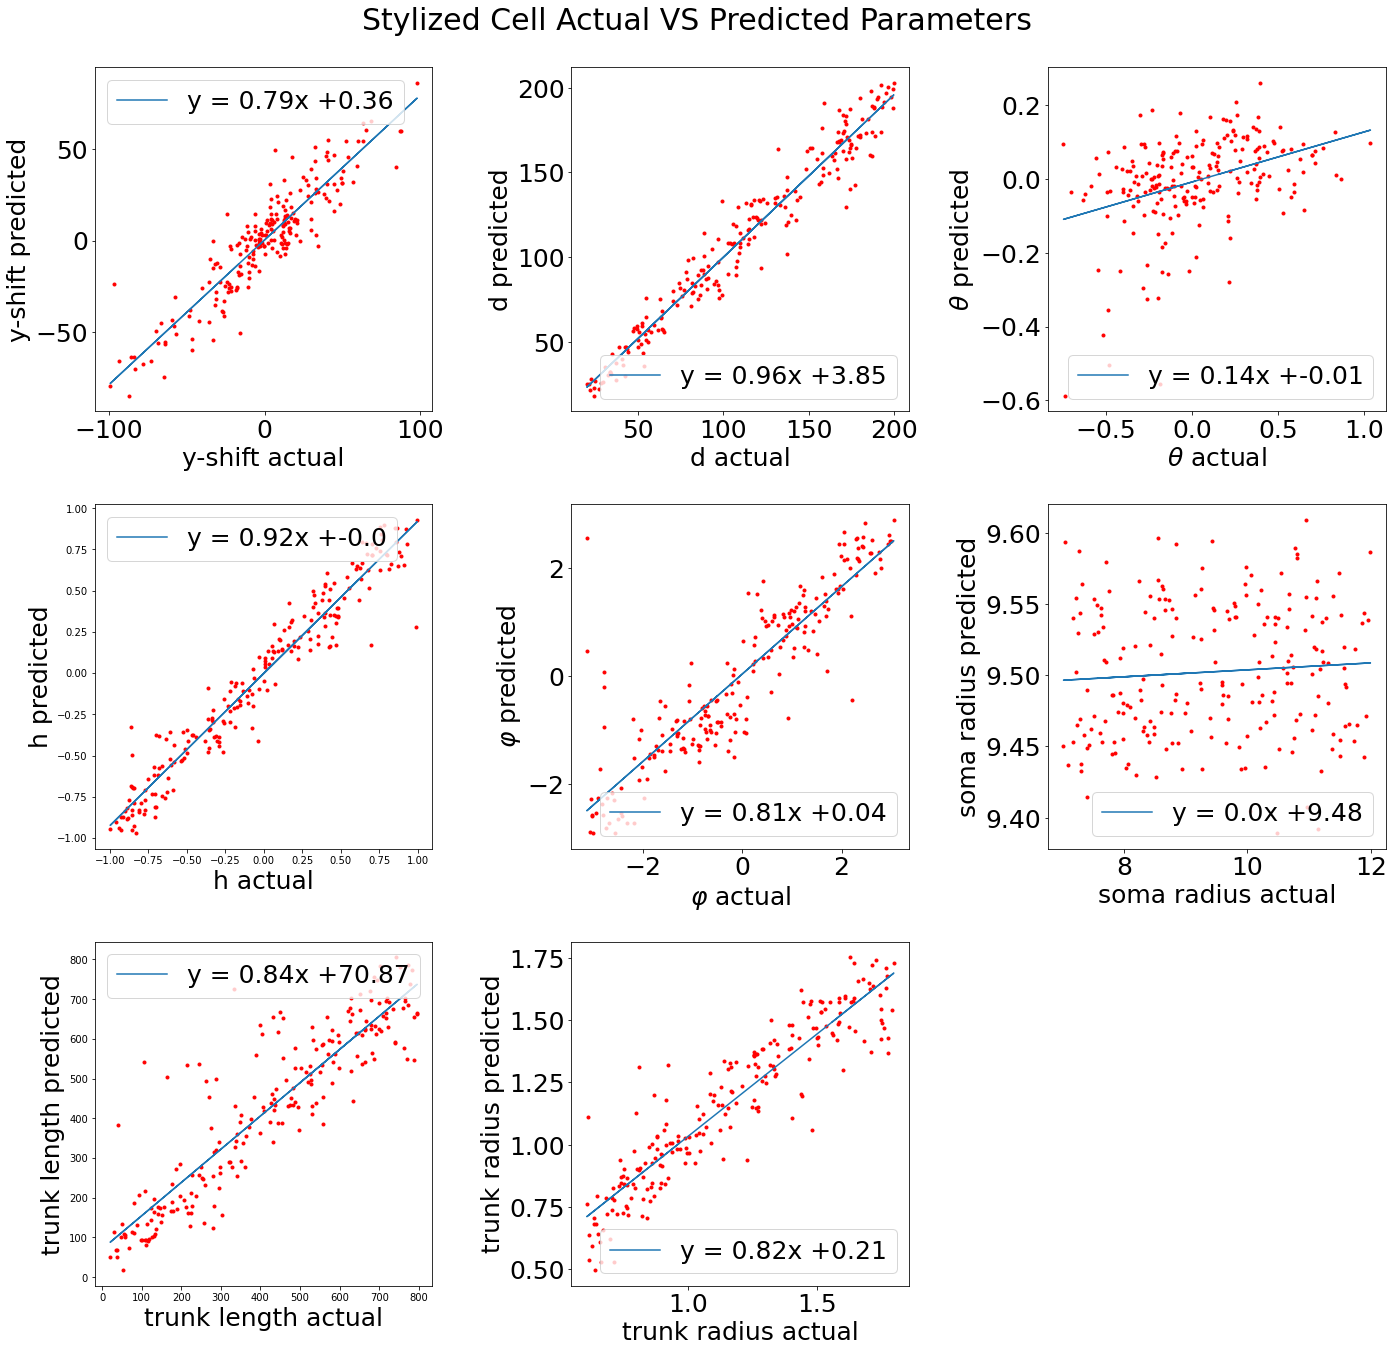

In [9]:
%matplotlib inline

idx = 0

plt.figure(figsize=(20,20))

plt.suptitle("Stylized Cell Actual VS Predicted Parameters", fontsize=30)
fontsize = 25
labelsize = 25

lab_ax = 0
ax = plt.subplot(331)
ax.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label='y = '+ str(round(m,2)) + 'x +' + str(round(b,2)))
ax.set_xlabel('y-shift actual', fontsize=fontsize)
ax.set_ylabel('y-shift predicted', fontsize=fontsize)
ax.tick_params(labelsize=labelsize)
ax.legend(fontsize=labelsize)

lab_ax = 1
ax = plt.subplot(332)
ax.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label='y = '+ str(round(m,2)) + 'x +' + str(round(b,2)))
ax.set_xlabel('d actual', fontsize=fontsize)
ax.set_ylabel('d predicted', fontsize=fontsize)
ax.tick_params(labelsize=labelsize)
ax.legend(fontsize=labelsize)

lab_ax = 2
ax = plt.subplot(333)
ax.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label='y = '+ str(round(m,2)) + 'x +' + str(round(b,2)))
ax.set_xlabel(r'$\theta$ actual', fontsize=fontsize)
ax.set_ylabel(r'$\theta$ predicted', fontsize=fontsize)
ax.tick_params(labelsize=labelsize)
ax.legend(fontsize=labelsize)

lab_ax = 3
ax = plt.subplot(334)
ax.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label='y = '+ str(round(m,2)) + 'x +' + str(round(b,2)))
ax.set_xlabel('h actual', fontsize=fontsize)
ax.set_ylabel('h predicted', fontsize=fontsize)
ax.legend(fontsize=labelsize)

lab_ax = 4
ax = plt.subplot(335)
ax.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label='y = '+ str(round(m,2)) + 'x +' + str(round(b,2)))
ax.set_xlabel(r'$\varphi$ actual', fontsize=fontsize)
ax.set_ylabel(r'$\varphi$ predicted', fontsize=fontsize)
ax.tick_params(labelsize=labelsize)
ax.legend(fontsize=labelsize)

lab_ax = 5
ax = plt.subplot(336)
ax.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label='y = '+ str(round(m,2)) + 'x +' + str(round(b,2)))
ax.set_xlabel('soma radius actual', fontsize=fontsize)
ax.set_ylabel('soma radius predicted', fontsize=fontsize)
ax.tick_params(labelsize=labelsize)
ax.legend(fontsize=labelsize)

lab_ax = 6
ax = plt.subplot(337)
ax.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label='y = '+ str(round(m,2)) + 'x +' + str(round(b,2)))
ax.set_xlabel('trunk length actual', fontsize=fontsize)
ax.set_ylabel('trunk length predicted', fontsize=fontsize)
ax.legend(fontsize=labelsize)

lab_ax = 7
ax = plt.subplot(338)
ax.scatter(y[:,lab_ax], output[:,lab_ax], c='red', marker='.')
m, b = np.polyfit(y[:,lab_ax], output[:,lab_ax], 1)
ax.plot(y[:,lab_ax], m*y[:,lab_ax]+b, label='y = '+ str(round(m,2)) + 'x +' + str(round(b,2)))
ax.set_xlabel('trunk radius actual', fontsize=fontsize)
ax.set_ylabel('trunk radius predicted', fontsize=fontsize)
ax.tick_params(labelsize=labelsize)
ax.legend(fontsize=labelsize)

plt.tight_layout(pad=3., rect=[0, 0.03, 1, 1])
plt.show()

In [10]:
from cell_inference.utils.feature_extractors.SummaryStats2D import get_y_window
from tqdm.notebook import tqdm
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

DATA_PATH = 'cell_inference/resources/invivo'

INVIVO_PATH = os.path.join(DATA_PATH, 'all_cell_LFP_2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    print(f.keys())
    c = f['coord'][:]
    d = f['data'][:]  # time x channels x samples
    ids = f['ID'][:]

t = np.arange(d.shape[0])

scaler = 7720.0

filtered_lfp = np.divide(d, scaler)

pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
lfp_list = []
for i in range(d.shape[2]):
    #     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    fst_idx = first_pk_tr(filtered_lfp[:,:,i])
    start, end = get_spike_window(filtered_lfp[:,:,i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(filtered_lfp[start:end, :, i])

windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)

test_data = []
summ_stats = []
bad_indices = []
y_pos = []
for i in tqdm(range(windowed_lfp.shape[0])):
    try:
        g_lfp, g_coords, y_i = build_lfp_grid(windowed_lfp[i, :, :], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        # windowed_lfp = np.delete(windowed_lfp, i, axis=0)
        # self.labels = np.delete(self.labels, i, axis=0)
        bad_indices.append(i)
        continue
    test_data.append(g_lfp)
    summ_stats.append(calculate_stats(g_lfp))
    y_pos.append(y_i)
    
ids = np.delete(ids, bad_indices, axis=0)
test_data = np.stack(test_data, axis=0)
summ_stats = np.array(summ_stats)
y_pos = np.stack(y_pos, axis=0)
print(test_data.shape, summ_stats.shape, y_pos.shape)

<KeysViewHDF5 ['ID', 'coord', 'data', 'fs', 'grid']>


  0%|          | 0/383 [00:00<?, ?it/s]

(359, 176, 196) (359, 40) (359,)


In [11]:
y_pos = y_pos.reshape((-1,))
# print(y_pos)

np.set_printoptions(suppress=True)

model.eval()
summ_stats = torch.Tensor(summ_stats)
summ_stats_tensor = summ_stats.to(device)
pred = model(summ_stats_tensor)
pred = pred.to("cpu").detach().numpy()

# print(pred[:, 0].shape)

if True:
    for i in range(pred.shape[1]):
        old_pred = pred[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_pred = (((old_pred - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        pred[:,i] = org_pred

pred[:,0] = y_pos - pred[:, 0]


# idx_map = np.stack((np.arange(ids.shape[0]), ids), axis=-1)
# idx_map = dict(enumerate(ids.flatten()))
print(ids.flatten())
# print(idx_map)
        
y_pred = pred
df = pd.DataFrame(y_pred, columns=inference_list)#.sort_values(by='y')
# df = df.rename(index=idx_map)
df['cell_id'] = ids.flatten()
# df = df[df['y'].between(-700,700)]
display(df)

[ 43.  45.  50.  51.  53.  54.  59.  63.  64.  68.  69.  70.  77.  78.
  79.  80.  82.  85.  87.  88.  89.  90.  92.  93.  95.  96.  97.  99.
 100. 101. 103. 104. 106. 108. 110. 112. 114. 116. 117. 128. 130. 133.
 135. 136. 138. 140. 141. 142. 144. 145. 146. 148. 149. 150. 151. 152.
 154. 156. 167. 169. 170. 171. 173. 174. 175. 176. 180. 183. 184. 185.
 187. 189. 190. 191. 193. 198. 199. 200. 201. 203. 204. 205. 206. 207.
 211. 214. 219. 220. 221. 225. 226. 227. 229. 231. 232. 236. 237. 239.
 248. 251. 252. 253. 254. 258. 259. 260. 263. 266. 269. 270. 273. 274.
 275. 276. 277. 281. 284. 288. 297. 305. 312. 313. 314. 320. 325. 326.
 328. 329. 334. 340. 343. 344. 346. 347. 348. 349. 355. 394. 395. 396.
 398. 399. 403. 405. 406. 407. 408. 409. 410. 411. 413. 414. 415. 416.
 417. 419. 420. 423. 424. 425. 429. 430. 431. 433. 435. 436. 437. 438.
 440. 441. 443. 444. 447. 449. 450. 452. 457. 459. 460. 486. 487. 491.
 493. 494. 496. 497. 498. 499. 500. 501. 502. 503. 504. 505. 506. 507.
 510. 

,y,d,theta,h,phi,r_s,l_t,r_t,cell_id
0,-1368.719971,62.023514,-0.002860,-0.222666,-0.015431,9.425841,604.733215,0.607210,43.0
1,-1382.687866,106.460007,0.076817,0.790841,-0.140505,9.443980,421.107269,0.902523,45.0
2,-1272.017944,212.312363,0.017711,0.175436,0.717517,9.453875,19.248184,0.638406,50.0
3,-1309.159058,138.237564,-0.040580,-0.534735,-2.319022,9.408116,100.601875,0.384209,51.0
4,-1118.767456,69.230362,-0.363424,-0.167263,-0.298180,9.505992,571.550781,0.923975,53.0
...,...,...,...,...,...,...,...,...,...
354,574.588501,85.758606,0.128624,0.804858,-0.240944,9.391064,689.056458,0.610396,438.0
355,696.194092,61.077812,0.110740,0.418435,-0.145061,9.397923,731.575928,0.612155,442.0
356,686.272461,76.564102,0.222774,0.854503,-0.052162,9.462268,635.037903,1.217864,445.0
357,646.440430,166.371841,0.057589,0.344622,-1.143009,9.412336,803.297913,0.626728,448.0


In [13]:
df['r_s'] = df['r_s'].clip(ranges['r_s'][0], ranges['r_s'][1])
df['l_t'] = df['l_t'].clip(ranges['l_t'][0], ranges['l_t'][1])
df['r_t'] = df['r_t'].clip(ranges['r_t'][0], ranges['r_t'][1])

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,y,d,theta,h,phi,r_s,l_t,r_t,cell_id
0,-1368.719971,62.023514,-0.002860,-0.222666,-0.015431,9.425841,604.733215,0.607210,43.0
1,-1382.687866,106.460007,0.076817,0.790841,-0.140505,9.443980,421.107269,0.902523,45.0
2,-1272.017944,212.312363,0.017711,0.175436,0.717517,9.453875,20.000000,0.638406,50.0
3,-1309.159058,138.237564,-0.040580,-0.534735,-2.319022,9.408116,100.601875,0.600000,51.0
4,-1118.767456,69.230362,-0.363424,-0.167263,-0.298180,9.505992,571.550781,0.923975,53.0
5,-1267.540649,248.479111,-0.253050,0.070113,1.989588,9.443049,45.148643,0.726619,54.0
6,-1066.906250,176.403687,-0.250811,0.185009,-1.578990,9.514915,341.890045,1.073039,59.0
7,-978.312866,137.368942,-0.166676,1.594574,-2.645525,9.452254,20.000000,0.930641,63.0
8,-812.322449,162.870239,-0.515637,-0.024796,-2.878758,9.546818,318.063141,1.142670,64.0
9,-847.666199,94.709511,-0.126560,-0.379413,-0.281844,9.439924,722.247986,0.600000,68.0


In [15]:
t = np.arange(test_data.shape[1])

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) & 
         (g_coords[:,1]>=ylim[0]) & 
         (g_coords[:,1]<=ylim[1]))

In [16]:
from cell_inference.utils.metrics.prediction_verification import InVivoParamSimulator

simu = InVivoParamSimulator(df)
lfp, t = simu.verify_and_save(save=False)

print(lfp.shape)
data_set = []
bad_indices = []
for i in tqdm(range(lfp.shape[0])):
    try:
        g_lfp, g_coords, y_i = build_lfp_grid(lfp[i, :, :], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        bad_indices.append(i)
        continue
    data_set.append(g_lfp)
data_set = np.stack(data_set, axis=0)

test_data = np.delete(test_data, bad_indices, axis=0)
ids = np.delete(ids, bad_indices, axis=0)
df = df.drop(index=bad_indices)

/home/matt/PycharmProjects/Stylized-Cell-Inference/cell_inference/utils/currents/ecp.py:109: RuntimeWarning: invalid value encountered in arccos
  rot = Rotation.from_euler('yxy', [rotate[0], np.arccos(rotate[1]), rotate[2]])


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Number of invalid samples: 0 out of 359
(359, 176, 384)


  0%|          | 0/359 [00:00<?, ?it/s]

(343, 176, 196)
(343, 176, 196)


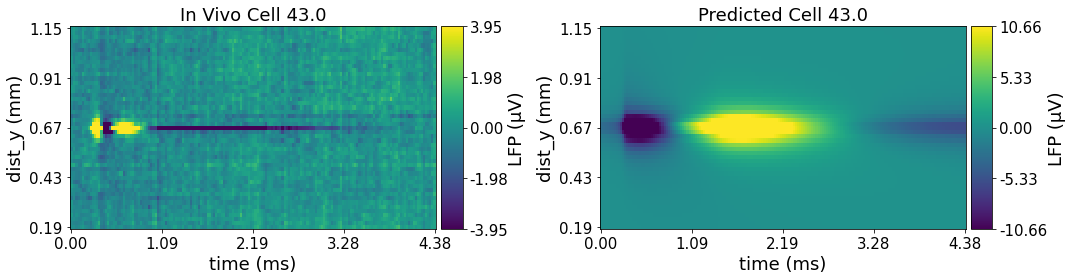

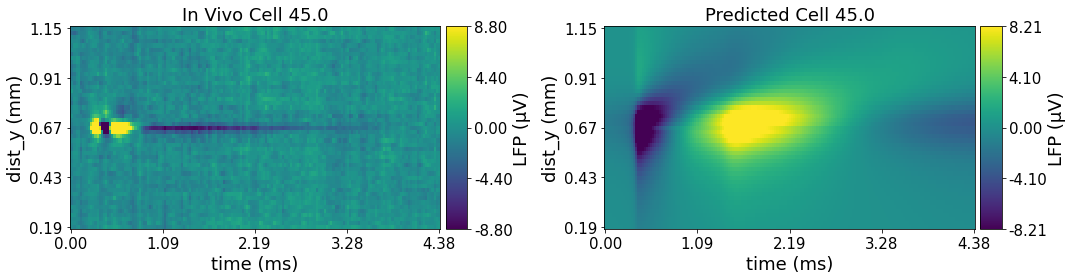

In [52]:
%matplotlib inline
from importlib import reload
import cell_inference.utils.plotting.plot_results
reload(cell_inference.utils.plotting.plot_results)
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from cell_inference.utils.plotting.plot_results import plot_multiple_lfp_heatmaps

start = 42
end = 45

# print(bad_indices)

# fig=plt.figure(figsize=(15,10))
# outer=GridSpec(1,2)


print(test_data.shape)
print(data_set.shape)

# ax1=fig.add_subplot(gs[0,:]) 
# ax2=fig.add_subplot(gs[1,0]) 
# ax3=fig.add_subplot(gs[1,1]) 


for i, row in df.iterrows():
    fig=plt.figure(figsize=(15,4))
    outer=GridSpec(1,2)
    
#     In Vivo Plot
    plot_multiple_lfp_heatmaps(t,
                                   g_coords[e_idx, 1],
                                   np.transpose(test_data[i,:,e_idx]), 
#                                    savefig='lfp_heatmaps/realinvivo' + str(i) + '.jpg',
                                   vlim='auto',
                                   fontsize=18,labelpad=0,ticksize=15,nbins=5,
                                   fig=fig, outer=outer, col=0, cell_num=0, title='In Vivo Cell {}'.format(row['cell_id']))

    # Predicted In Vivo From Params
    plot_multiple_lfp_heatmaps(t,
                                   g_coords[e_idx, 1],
                                   np.transpose(data_set[i,:,e_idx]), 
#                                    savefig='lfp_heatmaps/predictedinvivo' + str(i) + '.jpg',
                                   vlim='auto',
                                   fontsize=18,labelpad=0,ticksize=15,nbins=5,
                                   fig=fig, outer=outer, col=1, cell_num=0, title='Predicted Cell {}'.format(row['cell_id']))

    plt.tight_layout()
    
    plt.savefig('lfp_heatmaps/' + str(index) + '.jpg')
    if i == 1:
        break
# plt.show()

In [48]:
df.to_pickle('invivo_df.pkl')

Max Index: 190
Min Index: 26


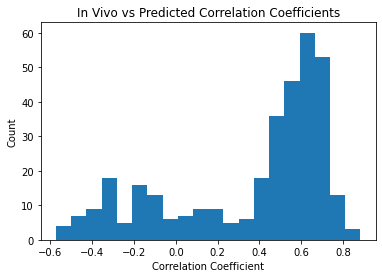

In [29]:
from cell_inference.utils.metrics.corrcoef import corrcoef

corrcoef_list = np.array([corrcoef(test_data[i,:,:], data_set[i,:,:]) for i in range(data_set.shape[0])])

maidx = np.argmax(corrcoef_list)
miidx = np.argmin(corrcoef_list)
print('Max Index: {}'.format(maidx))
print('Min Index: {}'.format(miidx))

plt.hist(corrcoef_list, bins=20)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Count')
plt.title('In Vivo vs Predicted Correlation Coefficients')
plt.show()

97.0
502.0


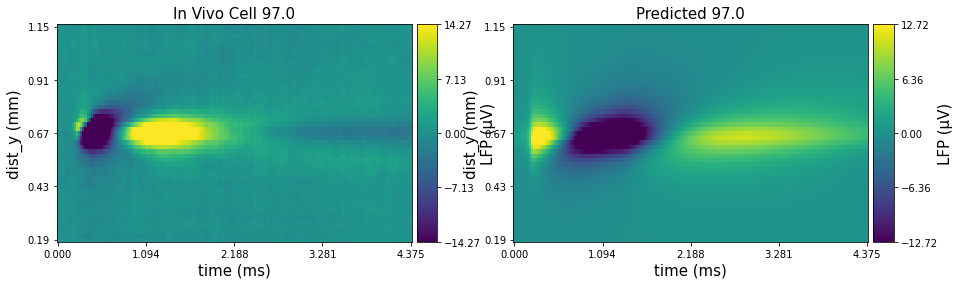

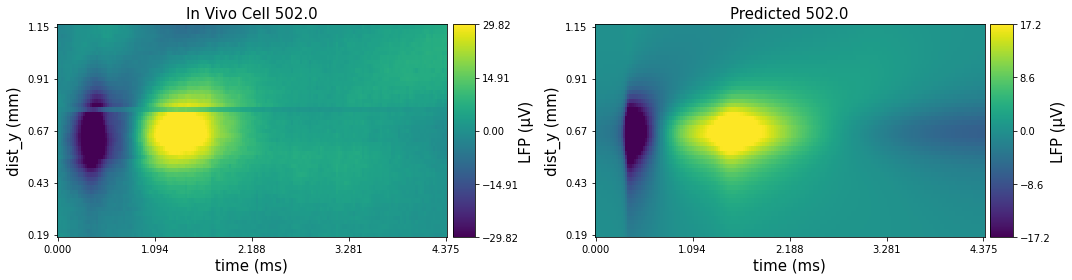

In [34]:
# fig=plt.figure(figsize=(15,10))

for i in [miidx, maidx]:
    fig=plt.figure(figsize=(15,4))
    outer=GridSpec(1,2)
    print(df.loc[i, 'cell_id'])
#     In Vivo Plot
    plot_multiple_lfp_heatmaps(t,
                                   g_coords[e_idx, 1],
                                   np.transpose(test_data[i,:,e_idx]), 
#                                    savefig='lfp_heatmaps/realinvivo' + str(i) + '.jpg',
                                   vlim='auto',
                                   fontsize=15,labelpad=0,ticksize=10,nbins=5,
                                   fig=fig, outer=outer, col=0, cell_num=0, title='In Vivo Cell {}'.format(df.loc[i, 'cell_id']))

    # Predicted In Vivo From Params
    plot_multiple_lfp_heatmaps(t,
                                   g_coords[e_idx, 1],
                                   np.transpose(data_set[i,:,e_idx]), 
#                                    savefig='lfp_heatmaps/predictedinvivo' + str(i) + '.jpg',
                                   vlim='auto',
                                   fontsize=15,labelpad=0,ticksize=10,nbins=5,
                                   fig=fig, outer=outer, col=1, cell_num=0, title='Predicted {}'.format(df.loc[i, 'cell_id']))
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


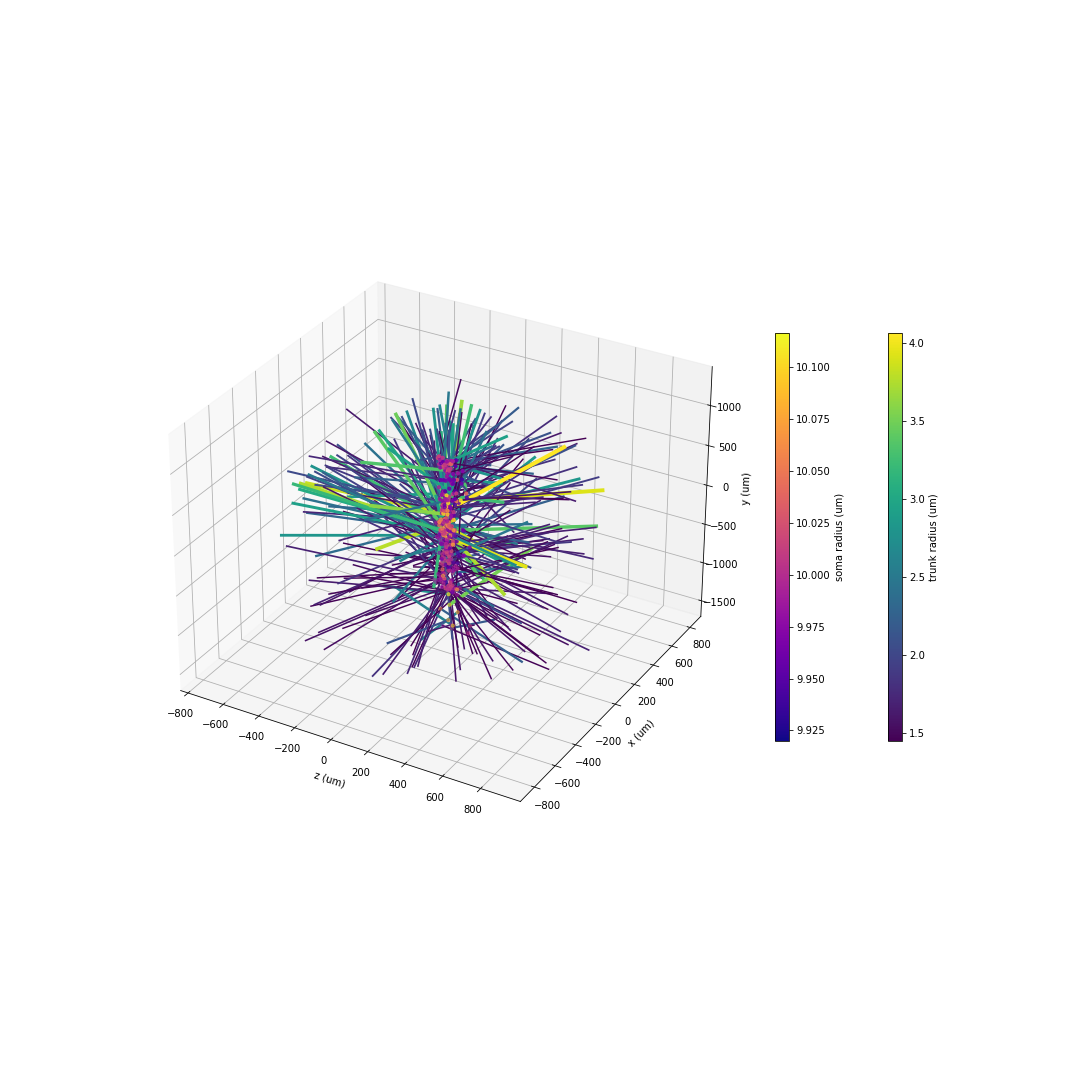

In [35]:
%matplotlib notebook

from importlib import reload
# import cell_inference.utils.plotting.plot_all_cells
# reload(cell_inference.utils.plotting.plot_all_cells)
from cell_inference.utils.plotting.plot_all_cells import plot_all_cells

fig, ax = plot_all_cells(df, figsize=(15., 15.))
ax.autoscale()

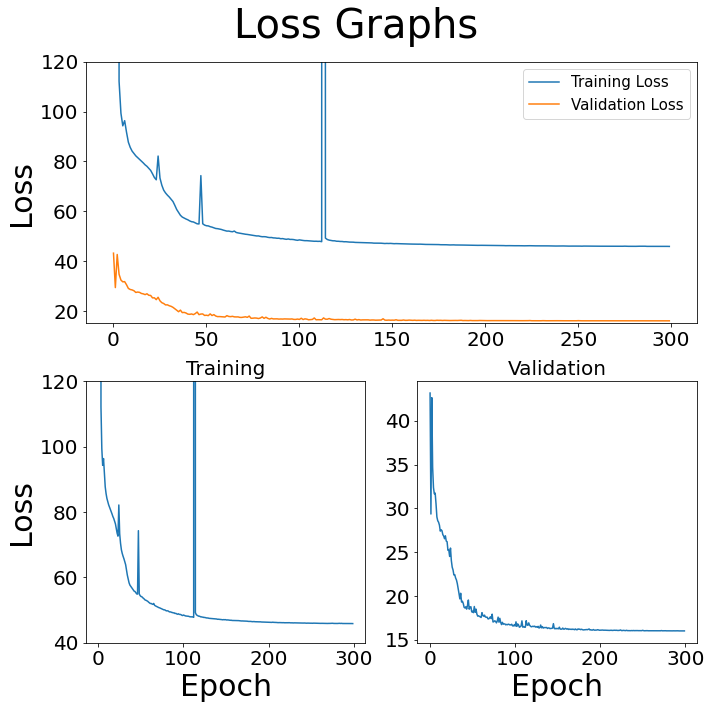

In [41]:
%matplotlib inline
import pandas as pd
from matplotlib.gridspec import GridSpec

LOSS_PATH = 'cell_inference/resources/results/pytorch_losses/13_43_39__02_14_2022.csv'
loss_df = pd.read_csv(LOSS_PATH)

t_loss = loss_df['Training_Loss'].to_numpy() # / 86729
epochs = np.arange(t_loss.shape[0])

v_loss = loss_df['Validation_Loss'].to_numpy() # / 28910


fig=plt.figure(figsize=(10,10))

fig.suptitle("Loss Graphs", fontsize=40)
gs=GridSpec(2,2)

ax1=fig.add_subplot(gs[0,:]) 
ax2=fig.add_subplot(gs[1,0]) 
ax3=fig.add_subplot(gs[1,1]) 

ax1.plot(epochs, t_loss, label='Training Loss')
ax1.plot(epochs, v_loss, label='Validation Loss')
ax1.tick_params(labelsize=20)
ax1.set_ylim(bottom=15, top=120)
# ax1.set_xlabel('Epoch', fontsize=40)
ax1.set_ylabel('Loss', fontsize=30)
ax1.legend(fontsize=15)

ax2.plot(epochs, t_loss, label='Training Loss')
ax2.tick_params(labelsize=20)
ax2.set_ylim(bottom=40, top=120)
ax2.set_xlabel('Epoch', fontsize=30)
ax2.set_ylabel('Loss', fontsize=30)
ax2.set_title('Training', fontsize=20)

ax3.plot(epochs, v_loss, label='Validation Loss')
ax3.tick_params(labelsize=20)
ax3.set_xlabel('Epoch', fontsize=30)
ax3.set_title('Validation', fontsize=20)
# ax3.set_ylabel('Loss', fontsize=40)

plt.tight_layout()
plt.show()
# print(t_loss)
# display(loss_df)